In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
# If the base path is the current directory, we can set the base_dir to an empty string
base_dir = ''

# Create lists to store image paths and labels again
image_paths = []
labels = []

# Iterate over each folder ('yes' for tumors, 'no' for non-tumors)
for folder in ['yes', 'no']:
    # Construct the full path to the folder
    folder_path = os.path.join(base_dir, folder)
    
    # List all jpg images in the folder
    for image in os.listdir(folder_path):
        if image.endswith('.jpg'):
            # Append the full image path to the image_paths list
            image_paths.append(os.path.join(folder_path, image))
            # Append the label to the labels list ('yes' for tumor, 'no' for non-tumor)
            labels.append(folder)

# Create a DataFrame with the paths and labels
df_images = pd.DataFrame({
    'ImagePath': image_paths,
    'Label': labels
})

# Display the first few rows of the DataFrame
df_images


,ImagePath,Label
0,yes\y0.jpg,yes
1,yes\y1.jpg,yes
2,yes\y10.jpg,yes
3,yes\y100.jpg,yes
4,yes\y1000.jpg,yes
...,...,...
2995,no\no995.jpg,no
2996,no\no996.jpg,no
2997,no\no997.jpg,no
2998,no\no998.jpg,no


In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

# Splitting the data
train_df, temp_df = train_test_split(df_images, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
test_df

,ImagePath,Label
2986,no\no987.jpg,no
410,yes\y1367.jpg,yes
1920,no\no1376.jpg,no
2724,no\no750.jpg,no
2677,no\no708.jpg,no
...,...,...
1732,no\no1206.jpg,no
2233,no\no308.jpg,no
1211,yes\y739.jpg,yes
812,yes\y38.jpg,yes



Found 2400 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.




Epoch 1/100



75/75 [==============================] - 33s 319ms/step - loss: 0.8310 - accuracy: 0.7788 - val_loss: 0.9553 - val_accuracy: 0.4653 - lr: 0.0010
Epoch 2/100
75/75 [==============================] - 22s 287ms/step - loss: 0.4871 - accuracy: 0.8325 - val_loss: 0.8562 - val_accuracy: 0.5868 - lr: 0.0010
Epoch 3/100
75/75 [==============================] - 21s 277ms/step - loss: 0.4226 - accuracy: 0.8600 - val_loss: 0.6539 - val_accuracy: 0.7083 - lr: 0.0010
Epoch 4/100
75/75 [==============================] - 20s 271ms/step - loss: 0.3849 - accuracy: 0.8783 - val_loss: 1.1673 - val_accuracy: 0.5903 - lr: 0.0010
Epoch 5/100
75/75 [==============================] - 22s 287ms/step - loss: 0.3639 - accuracy: 0.8833 - val_loss: 0.7628 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 6/100
75/75 [==============================] - 21s 275ms/step - loss: 0.3604 - accuracy: 0.8800 - val_loss: 0.9926 - val_accuracy: 0.6007 - lr: 0.0010
Epoch 7/100
75/75 [==============================] - 21s 278ms/step - 

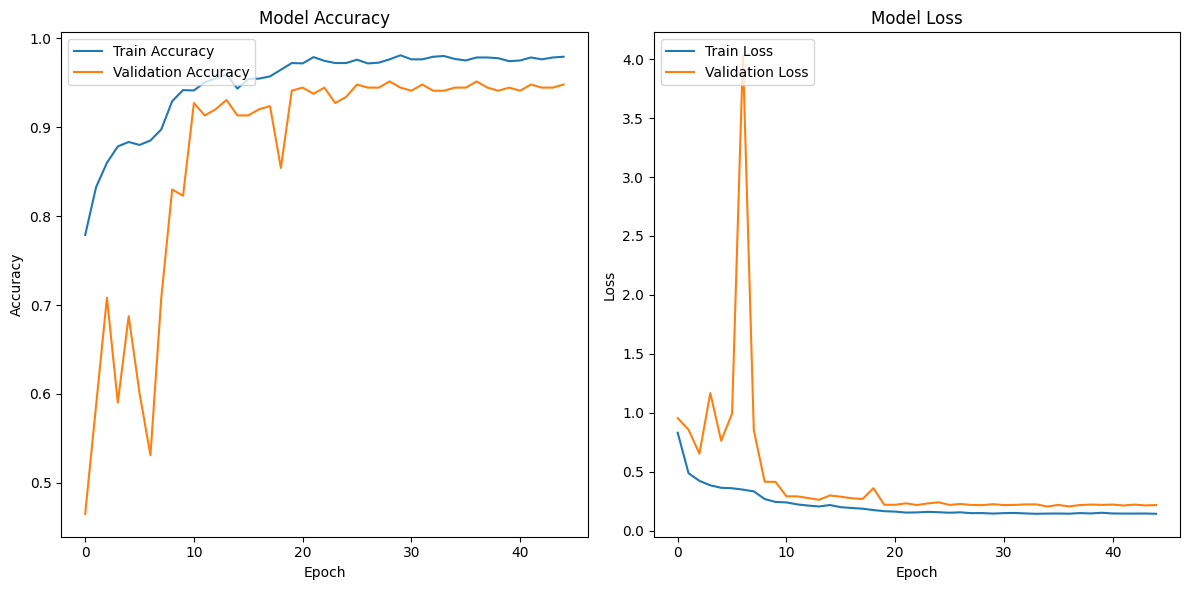

9/9 [==============================] - 1s 107ms/step - loss: 0.3086 - accuracy: 0.9271
Test accuracy: 92.71%


In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

# Splitting the data
train_df, temp_df = train_test_split(df_images, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Data generator without augmentation (only rescaling)
datagen = ImageDataGenerator(rescale=1./255)

# Flow data from DataFrame
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='ImagePath',
    y_col='Label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='ImagePath',
    y_col='Label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='ImagePath',
    y_col='Label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Model construction using ResNet50 as base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)

# A simplified model with L2 regularization
x = Dense(1024, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Final layer for binary classification
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freezing the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Model compilation
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Model training with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=100, # Adjust as needed
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Plotting the training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Model evaluation on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
print(f"Test accuracy: {test_acc*100:.2f}%")


Found 300 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


Epoch 1/100
75/75 [==============================] - 12s 143ms/step - loss: 0.8434 - accuracy: 0.7658 - val_loss: 0.7946 - val_accuracy: 0.4826 - lr: 0.0010
Epoch 2/100
75/75 [==============================] - 10s 132ms/step - loss: 0.4841 - accuracy: 0.8317 - val_loss: 0.7439 - val_accuracy: 0.5694 - lr: 0.0010
Epoch 3/100
75/75 [==============================] - 10s 134ms/step - loss: 0.4162 - accuracy: 0.8550 - val_loss: 0.7639 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 4/100
75/75 [==============================] - 10s 131ms/step - loss: 0.3774 - accuracy: 0.8746 - val_loss: 0.7894 - val_accuracy: 0.6389 - lr: 0.0010
Epoch 5/100
75/75 [==============================] - 10s 135ms/step - loss: 0.3741 - accuracy: 0.8763 - val_loss: 0.5492 - val_accuracy: 0.7674 - lr: 0.0010
Epoch 6/100
75/75 [==============================] - 10s 133ms/step - loss: 0.3484 - accuracy: 0.8863 - val_loss: 0.5166 - val_accuracy: 0.8160 - lr: 0.0010
Epoch 7/100
75/75 [==============================] - 10s 1

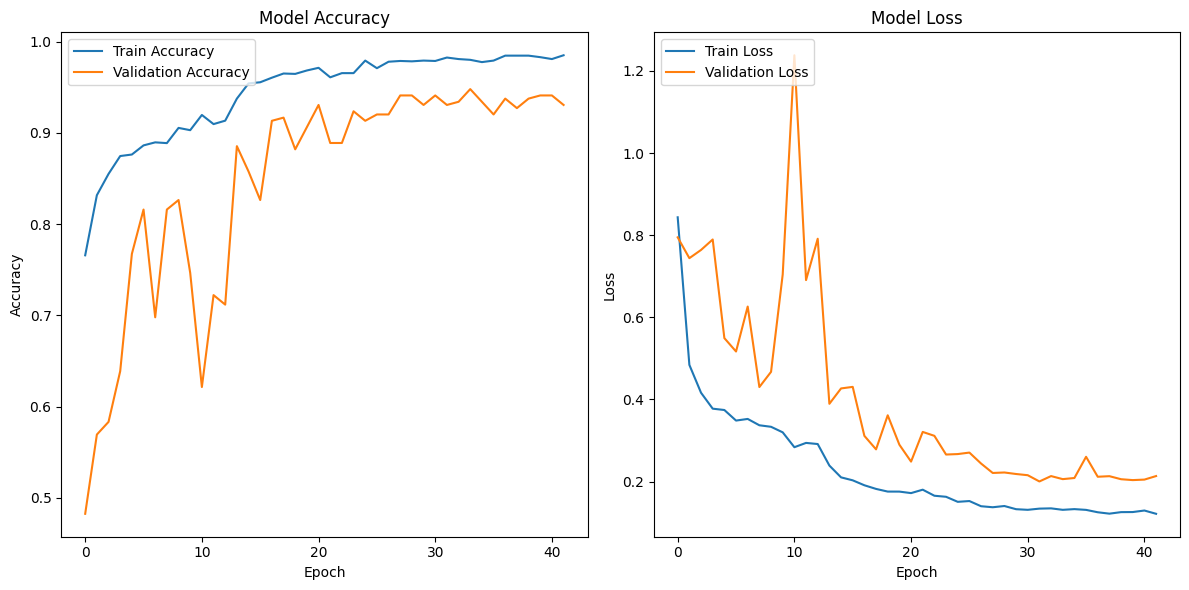

9/9 [==============================] - 1s 117ms/step - loss: 0.3062 - accuracy: 0.9340
Test accuracy: 93.40%


In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

# Splitting the data
train_df, temp_df = train_test_split(df_images, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Data generator without augmentation (only rescaling)
datagen = ImageDataGenerator(rescale=1./255)

# Flow data from DataFrame
# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='ImagePath',
    y_col='Label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='ImagePath',
    y_col='Label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Model construction using ResNet50 as base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)

# A simplified model with L2 regularization
x = Dense(1024, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Final layer for binary classification
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freezing the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Model compilation
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Model training with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=100, # Adjust as needed
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Plotting the training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Model evaluation on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
print(f"Test accuracy: {test_acc*100:.2f}%")


In [4]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [11]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Function to create and compile the model
def create_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Assuming df_images is a DataFrame containing your image paths and labels
labels = df_images['Label'].values

# Define the K-fold cross-validator (stratified)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []

# K-fold Cross Validation model evaluation
for train, test in kfold.split(np.zeros(len(labels)), labels):
    train_df = df_images.iloc[train]
    test_df = df_images.iloc[test]
    
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    
    val_generator = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='ImagePath',
        y_col='Label',
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary'
    )
    
    test_generator = datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='ImagePath',
        y_col='Label',
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary',
        shuffle=False
    )

    
    model = create_model()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
    
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.n // train_generator.batch_size,
        epochs=100, # Adjust as needed
        validation_data=val_generator,
        validation_steps=val_generator.n // val_generator.batch_size,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    # Generate predictions
    test_generator.reset()
    predictions = model.predict(test_generator)
    y_pred = np.round(predictions).astype(int)
    y_true = test_generator.classes  # This should directly correspond to the predictions
    
    # Calculate and append metrics
    accuracies.append(accuracy_score(y_true, y_pred))
    precisions.append(precision_score(y_true, y_pred, zero_division=0))
    recalls.append(recall_score(y_true, y_pred, zero_division=0))
    f1_scores.append(f1_score(y_true, y_pred, zero_division=0))

# Calculate mean and standard deviation for each metric
accuracy = np.mean(accuracies), np.std(accuracies)
precision = np.mean(precisions), np.std(precisions)
recall = np.mean(recalls), np.std(recalls)
f1 = np.mean(f1_scores), np.std(f1_scores)

# Print the metrics
print(f'Accuracy: {accuracy[0]:.2f} ± {accuracy[1]:.2f}')
print(f'Precision: {precision[0]:.2f} ± {precision[1]:.2f}')
print(f'Recall: {recall[0]:.2f} ± {recall[1]:.2f}')
print(f'F1-score: {f1[0]:.2f} ± {f1[1]:.2f}')


Found 300 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.


Epoch 1/100
75/75 [==============================] - 22s 238ms/step - loss: 0.8573 - accuracy: 0.7642 - val_loss: 0.7892 - val_accuracy: 0.5035 - lr: 0.0010
Epoch 2/100
75/75 [==============================] - 15s 202ms/step - loss: 0.4812 - accuracy: 0.8350 - val_loss: 0.8119 - val_accuracy: 0.5035 - lr: 0.0010
Epoch 3/100
75/75 [==============================] - 15s 196ms/step - loss: 0.4270 - accuracy: 0.8562 - val_loss: 1.3125 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 4/100
75/75 [==============================] - 15s 203ms/step - loss: 0.4190 - accuracy: 0.8571 - val_loss: 1.0763 - val_accuracy: 0.5660 - lr: 0.0010
Epoch 5/100
75/75 [==============================] - 16s 207ms/step - loss: 0.3689 - accuracy: 0.8883 - val_loss: 0.8482 - val_accuracy: 0.6076 - lr: 0.0010
Epoch 6/100
75/75 [==============================] - 16s 211ms/step - loss: 0.3768 - accuracy: 0.8775 - val_loss: 0.5420 - val_accuracy: 0.7917 - lr: 0.0010
Epoch 7/100
75/75 [==============================] - 16s 2

Epoch 1/100
75/75 [==============================] - 23s 261ms/step - loss: 0.8491 - accuracy: 0.7767 - val_loss: 0.9465 - val_accuracy: 0.4653 - lr: 0.0010
Epoch 2/100
75/75 [==============================] - 18s 239ms/step - loss: 0.4984 - accuracy: 0.8225 - val_loss: 0.6645 - val_accuracy: 0.7743 - lr: 0.0010
Epoch 3/100
75/75 [==============================] - 16s 216ms/step - loss: 0.4287 - accuracy: 0.8596 - val_loss: 0.6948 - val_accuracy: 0.6493 - lr: 0.0010
Epoch 4/100
75/75 [==============================] - 16s 206ms/step - loss: 0.3990 - accuracy: 0.8667 - val_loss: 0.8575 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/100
75/75 [==============================] - 16s 215ms/step - loss: 0.3754 - accuracy: 0.8842 - val_loss: 0.4266 - val_accuracy: 0.8646 - lr: 0.0010
Epoch 6/100
75/75 [==============================] - 16s 215ms/step - loss: 0.3535 - accuracy: 0.8867 - val_loss: 1.7430 - val_accuracy: 0.6007 - lr: 0.0010
Epoch 7/100
75/75 [==============================] - 16s 2

Epoch 1/100
75/75 [==============================] - 22s 244ms/step - loss: 0.8678 - accuracy: 0.7558 - val_loss: 0.7938 - val_accuracy: 0.5521 - lr: 0.0010
Epoch 2/100
75/75 [==============================] - 16s 215ms/step - loss: 0.4940 - accuracy: 0.8292 - val_loss: 0.9199 - val_accuracy: 0.5104 - lr: 0.0010
Epoch 3/100
75/75 [==============================] - 18s 236ms/step - loss: 0.4290 - accuracy: 0.8508 - val_loss: 0.6586 - val_accuracy: 0.6944 - lr: 0.0010
Epoch 4/100
75/75 [==============================] - 17s 227ms/step - loss: 0.3841 - accuracy: 0.8675 - val_loss: 0.5381 - val_accuracy: 0.8472 - lr: 0.0010
Epoch 5/100
75/75 [==============================] - 19s 248ms/step - loss: 0.4020 - accuracy: 0.8633 - val_loss: 0.5061 - val_accuracy: 0.7986 - lr: 0.0010
Epoch 6/100
75/75 [==============================] - 17s 229ms/step - loss: 0.3564 - accuracy: 0.8854 - val_loss: 0.8195 - val_accuracy: 0.6319 - lr: 0.0010
Epoch 7/100
75/75 [==============================] - 17s 2

Epoch 1/100
75/75 [==============================] - 25s 239ms/step - loss: 0.8838 - accuracy: 0.7633 - val_loss: 1.1021 - val_accuracy: 0.4653 - lr: 0.0010
Epoch 2/100
75/75 [==============================] - 15s 203ms/step - loss: 0.5061 - accuracy: 0.8296 - val_loss: 0.8830 - val_accuracy: 0.4965 - lr: 0.0010
Epoch 3/100
75/75 [==============================] - 16s 215ms/step - loss: 0.4275 - accuracy: 0.8575 - val_loss: 0.8480 - val_accuracy: 0.5174 - lr: 0.0010
Epoch 4/100
75/75 [==============================] - 15s 198ms/step - loss: 0.4133 - accuracy: 0.8625 - val_loss: 0.5143 - val_accuracy: 0.8576 - lr: 0.0010
Epoch 5/100
75/75 [==============================] - 11s 141ms/step - loss: 0.3954 - accuracy: 0.8662 - val_loss: 0.9482 - val_accuracy: 0.6215 - lr: 0.0010
Epoch 6/100
75/75 [==============================] - 11s 140ms/step - loss: 0.3646 - accuracy: 0.8817 - val_loss: 0.5703 - val_accuracy: 0.7361 - lr: 0.0010
Epoch 7/100
75/75 [==============================] - 10s 1

Epoch 1/100
75/75 [==============================] - 13s 149ms/step - loss: 0.8626 - accuracy: 0.7638 - val_loss: 0.9722 - val_accuracy: 0.4792 - lr: 0.0010
Epoch 2/100
75/75 [==============================] - 11s 142ms/step - loss: 0.5019 - accuracy: 0.8308 - val_loss: 0.9165 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 3/100
75/75 [==============================] - 12s 162ms/step - loss: 0.4535 - accuracy: 0.8529 - val_loss: 0.8558 - val_accuracy: 0.6076 - lr: 0.0010
Epoch 4/100
75/75 [==============================] - 10s 138ms/step - loss: 0.3926 - accuracy: 0.8838 - val_loss: 0.5730 - val_accuracy: 0.7361 - lr: 0.0010
Epoch 5/100
75/75 [==============================] - 11s 141ms/step - loss: 0.3815 - accuracy: 0.8808 - val_loss: 0.4394 - val_accuracy: 0.8785 - lr: 0.0010
Epoch 6/100
75/75 [==============================] - 11s 143ms/step - loss: 0.3457 - accuracy: 0.8904 - val_loss: 0.8329 - val_accuracy: 0.6528 - lr: 0.0010
Epoch 7/100
75/75 [==============================] - 11s 1

Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.


Epoch 1/100
75/75 [==============================] - 14s 161ms/step - loss: 1.0727 - accuracy: 0.6313 - val_loss: 0.8447 - val_accuracy: 0.4965
Epoch 2/100
75/75 [==============================] - 12s 156ms/step - loss: 0.7663 - accuracy: 0.6642 - val_loss: 1.0152 - val_accuracy: 0.4965
Epoch 3/100
75/75 [==============================] - 12s 155ms/step - loss: 0.6852 - accuracy: 0.6992 - val_loss: 1.0939 - val_accuracy: 0.5035
Epoch 4/100
75/75 [==============================] - 12s 156ms/step - loss: 0.6571 - accuracy: 0.7033 - val_loss: 0.9156 - val_accuracy: 0.5434
Epoch 5/100
75/75 [==============================] - 12s 163ms/step - loss: 0.6919 - accuracy: 0.6721 - val_loss: 0.6761 - val_accuracy: 0.6510
Epoch 6/100
75/75 [==============================] - 15s 192ms/step - loss: 0.6452 - accuracy: 0.7133 - val_loss: 0.6122 - val_accuracy: 0.7413
Epoch 7/100
75/75 [==============================] - 13s 178ms/step - loss: 0.6237 - accuracy: 0.7033 - val_loss: 1.3778 - val_accuracy:

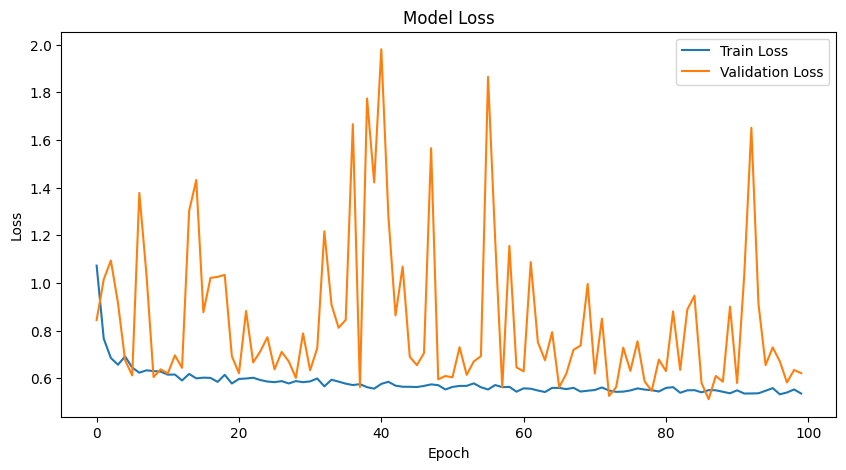

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
import matplotlib.pyplot as plt

# Function to create and compile the model
def create_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Assuming df_images is a DataFrame containing your image paths and labels
labels = df_images['Label'].values

# Split the data into training and testing sets
train_df, test_df = train_test_split(df_images, test_size=0.2, stratify=labels, random_state=42)

# Data augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data augmentation for validation and testing images
val_datagen = ImageDataGenerator(rescale=1./255)

# Create image generators for training, validation, and testing
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='ImagePath',
    y_col='Label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='ImagePath',
    y_col='Label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Create the model
model = create_model()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=100,  # Adjust as needed
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    verbose=1
)

# Plot loss and accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

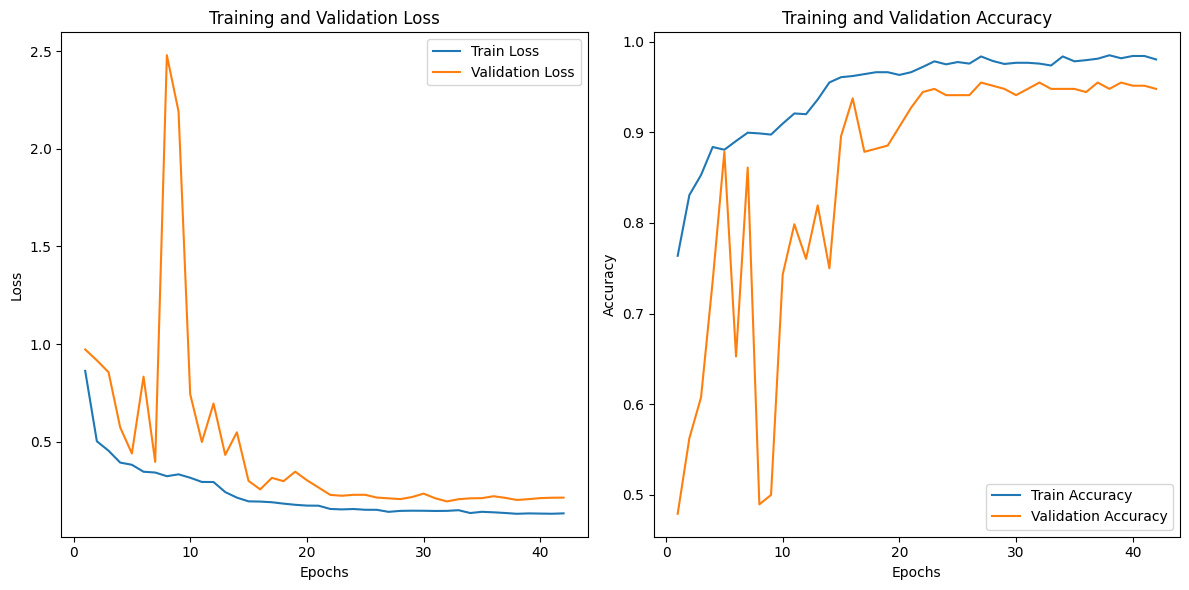

In [7]:
import matplotlib.pyplot as plt

# Data from your provided epochs
epochs = list(range(1, 43))
train_loss = [0.8626, 0.5019, 0.4535, 0.3926, 0.3815, 0.3457, 0.3417, 0.3228, 0.3324, 0.3150, 
              0.2934, 0.2930, 0.2415, 0.2131, 0.1940, 0.1928, 0.1894, 0.1823, 0.1763, 0.1722, 
              0.1717, 0.1551, 0.1527, 0.1547, 0.1508, 0.1506, 0.1402, 0.1451, 0.1461, 0.1457, 
              0.1447, 0.1452, 0.1486, 0.1341, 0.1404, 0.1378, 0.1343, 0.1302, 0.1322, 0.1313, 
              0.1304, 0.1324]
val_loss = [0.9722, 0.9165, 0.8558, 0.5730, 0.4394, 0.8329, 0.3961, 2.4800, 2.1922, 0.7428, 
            0.4982, 0.6953, 0.4321, 0.5478, 0.2989, 0.2552, 0.3143, 0.2974, 0.3460, 0.3022, 
            0.2650, 0.2272, 0.2226, 0.2275, 0.2275, 0.2133, 0.2094, 0.2055, 0.2159, 0.2335, 
            0.2098, 0.1937, 0.2049, 0.2095, 0.2104, 0.2202, 0.2119, 0.2011, 0.2053, 0.2105, 
            0.2126, 0.2130]
train_accuracy = [0.7638, 0.8308, 0.8529, 0.8838, 0.8808, 0.8904, 0.8996, 0.8988, 0.8975, 0.9096, 
                  0.9208, 0.9200, 0.9362, 0.9550, 0.9608, 0.9621, 0.9642, 0.9663, 0.9663, 0.9633, 
                  0.9663, 0.9721, 0.9783, 0.9750, 0.9775, 0.9758, 0.9837, 0.9787, 0.9754, 0.9767, 
                  0.9767, 0.9758, 0.9737, 0.9837, 0.9783, 0.9796, 0.9812, 0.9850, 0.9817, 0.9842, 
                  0.9842, 0.9804]
val_accuracy = [0.4792, 0.5625, 0.6076, 0.7361, 0.8785, 0.6528, 0.8611, 0.4896, 0.5000, 0.7431, 
                0.7986, 0.7604, 0.8194, 0.7500, 0.8958, 0.9375, 0.8785, 0.8819, 0.8854, 0.9062, 
                0.9271, 0.9444, 0.9479, 0.9410, 0.9410, 0.9410, 0.9549, 0.9514, 0.9479, 0.9410, 
                0.9479, 0.9549, 0.9479, 0.9479, 0.9479, 0.9444, 0.9549, 0.9479, 0.9549, 0.9514, 
                0.9514, 0.9479]

plt.figure(figsize=(12, 6))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
